# Setup

## Imports 

In [81]:
# Standard
import sys
from cycler import cycler
# Third party
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import proplot as plot
# Local                                                                        
sys.path.append('/Users/46h/Research/code/accphys/') 
from tools import (
    envelope_analysis as ea,
    plotting as myplt,
    utils
)

## Settings

In [82]:
# Plotting
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge
dpi = 500

# Load data

In [91]:
positions = np.load('_output/data/positions.npy')
positions_normed = positions / positions[-1]
costs = np.load('_output/data/costs.npy')

tracked_params_lists = {}
tracked_params_lists['tbt'] = np.load('_output/data/tbt_params_list.npy')
tracked_params_lists['sdep'] = np.load('_output/data/sdep_params_list.npy')

stats_lists = {}
for key in ('tbt', 'sdep'):
    stats_lists[key] = []
    for tracked_params in tracked_params_lists[key]:
        stats = ea.Stats(mode=1)
        stats.read_env(tracked_params)
        if key == 'sdep':
            for df in stats.dfs():
                df['s'] = positions
                df['s/L'] = positions_normed
        stats_lists[key].append(stats)
    stats_lists[key] = np.array(stats_lists[key])

# Plot 

In [92]:
plt_kws = dict(lw=None, marker=None, markersize=None, legend=False)
cmap = plot.Colormap('Blues')
colors = [cmap(i) for i in np.linspace(0, 1, len(stats_lists['tbt']))]
_cycler = cycler('color', colors)

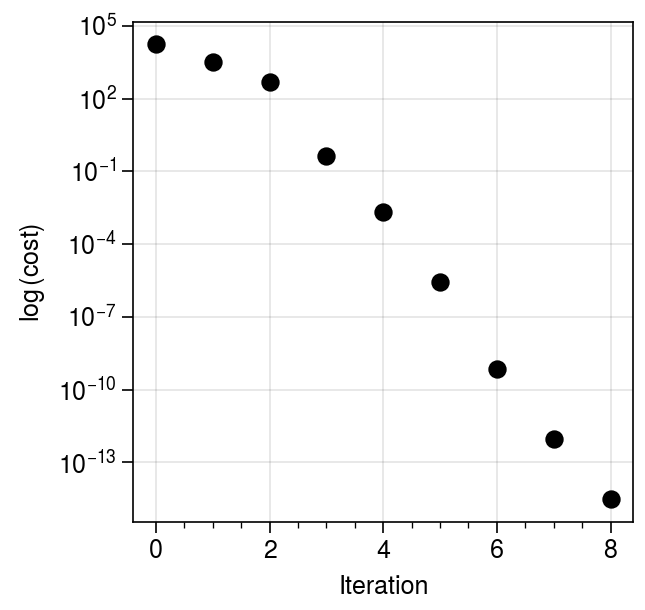

In [93]:
fig, ax = plot.subplots()
ax.scatter(costs, c='k')
ax.format(xlabel='Iteration', ylabel=r'$log\,(cost)$', yformatter='log', yscale='log')

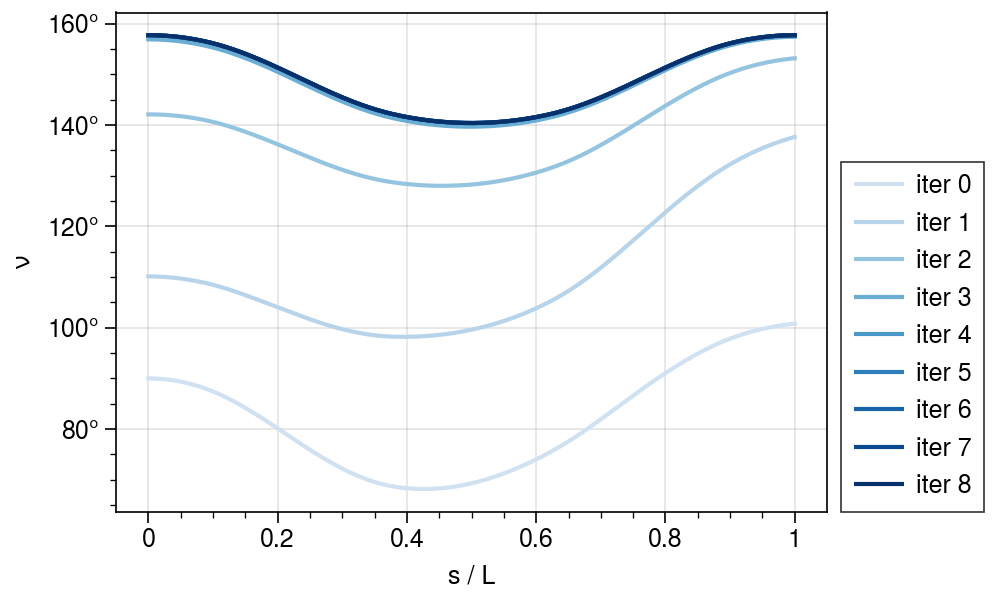

In [94]:
nshow = 9
fig, ax = plot.subplots(figsize=(5, 3))
ax.set_prop_cycle(cycler('color', [cmap(i) for i in np.linspace(0.2, 1, nshow)]))
for stats in stats_lists['sdep'][:nshow]:
    stats.twiss4D[['s/L','nu']].plot('s/L', ax=ax, **plt_kws)
ax.legend(labels=['iter {}'.format(i) for i in range(nshow)], ncols=1, loc=(1.02, 0))
ax.format(
    xlabel='s / L',
    ylabel=r'$\nu$',
    yformatter='deg'
)

### Turn-by-turn parameters 

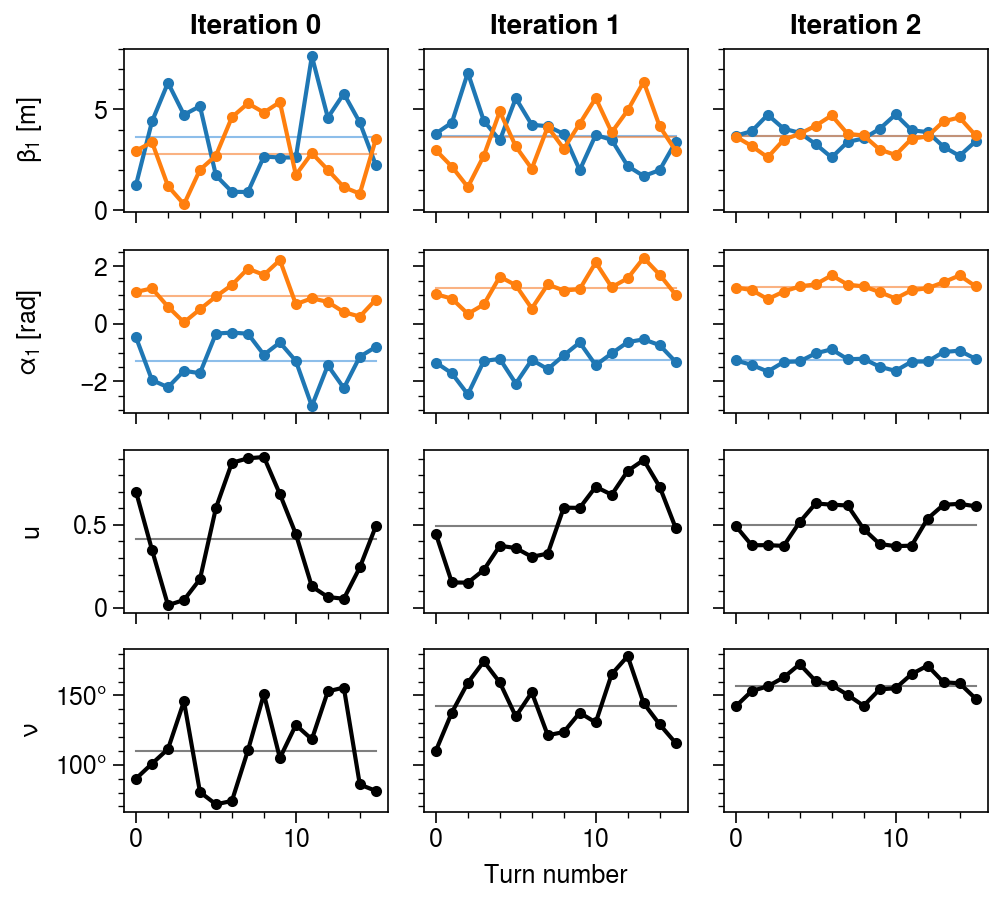

In [95]:
nshow = 3
data_kws = dict(lw=None, ls='-', marker='.', legend=False)
mean_kws = dict(lw=0.75, ls='-', alpha=0.5, zorder=0)

fig, axes = plot.subplots(nrows=4, ncols=nshow, figsize=(5, 4.5), spany=False, aligny=True)
for j, stats in enumerate(stats_lists['tbt'][:nshow]):
    n = stats.twiss4D.shape[0]
    for i, cols in enumerate([['bx','by'], ['ax','ay'], ['u'], ['nu']]):
        ax = axes[i, j]
        color = 'k' if len(cols) == 1 else None
        data = stats.twiss4D[cols]
        data.plot(ax=ax, color=color, **data_kws)
        if len(cols) > 1:
            xavg, yavg = data.mean()
            ax.plot(list(range(n)), n * [xavg], color='blue7', **mean_kws)
            ax.plot(list(range(n)), n * [yavg], color='orange7', **mean_kws)
        else:
            avg = data.mean()
            ax.plot(list(range(n)), n * [avg], color='k', **mean_kws)
    
axes.format(xlabel='Turn number', grid=False,
            toplabels=['Iteration {}'.format(i) for i in range(nshow)])
axes[-1, 0].format(yformatter='deg')
myplt.set_labels(axes[:, 0], [r'$\beta_{1}$ [m]', r'$\alpha_{1}$ [rad]', 'u', r'$\nu$'], 'ylabel')

plt.savefig('_output/figures/iters.png', dpi=dpi, facecolor='white')

### s-dependent parameters 

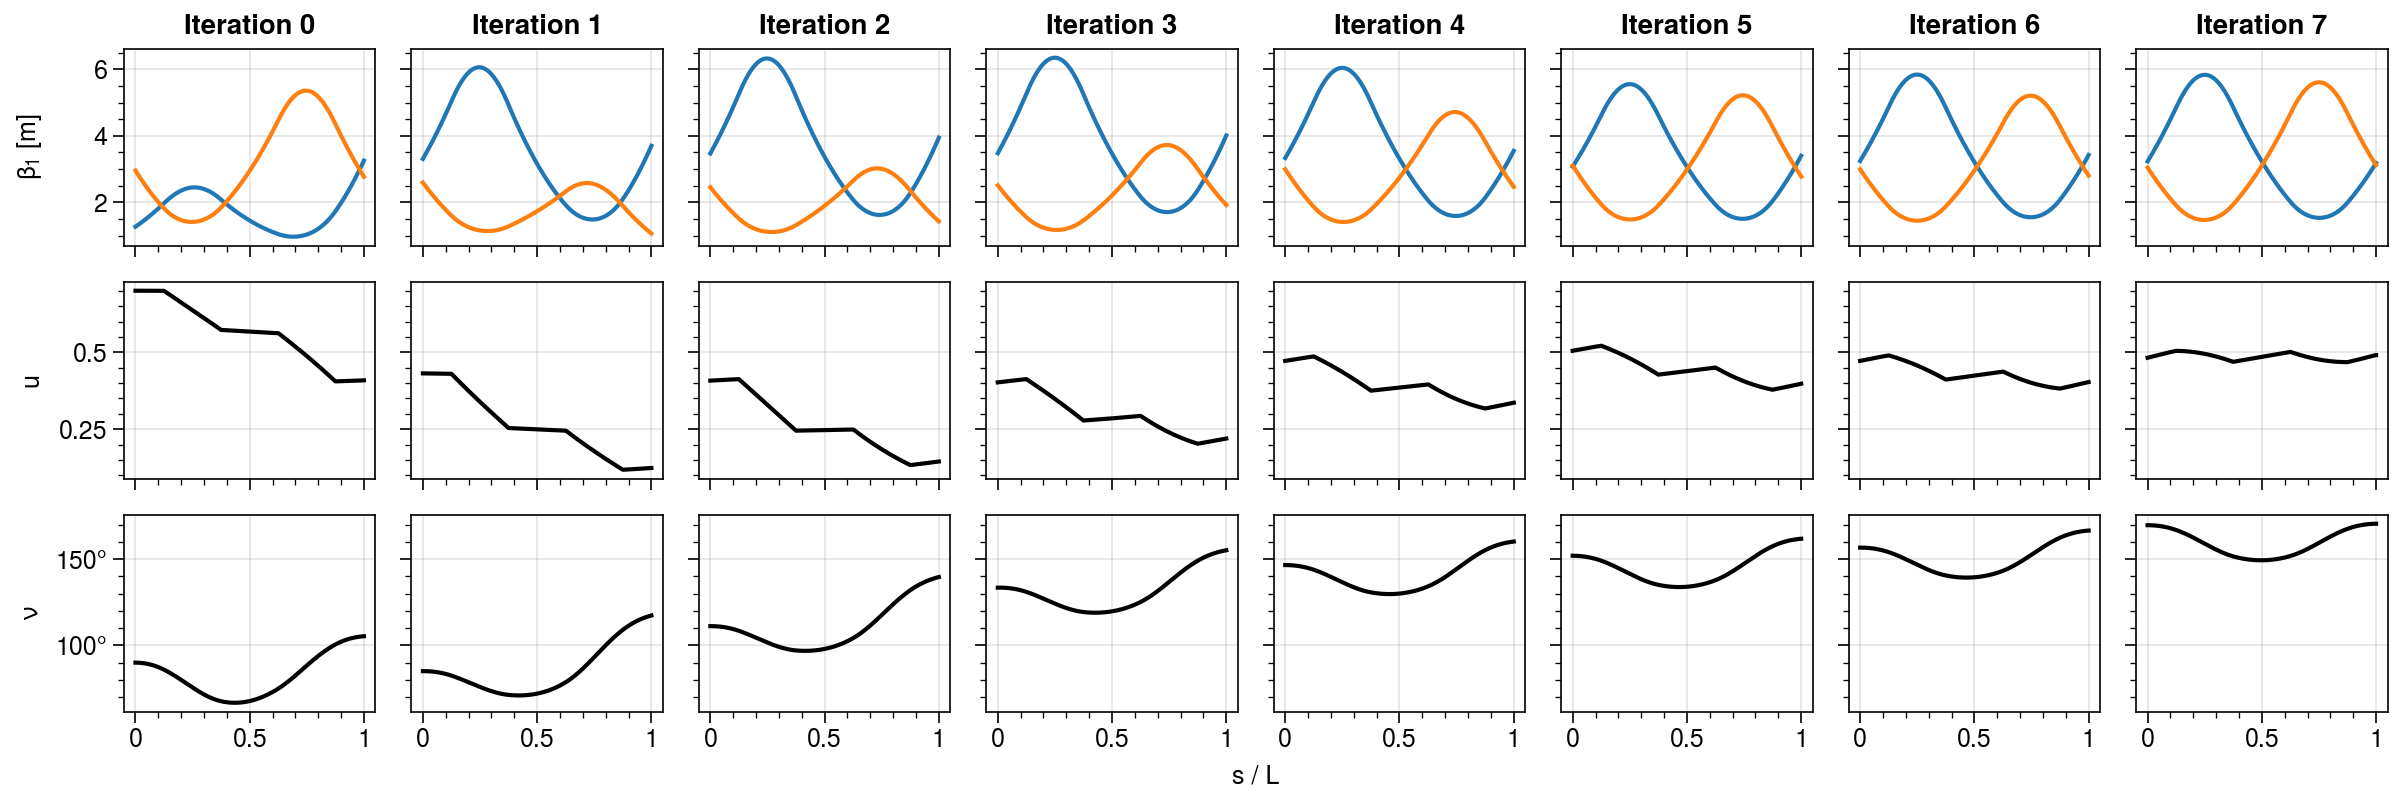

In [88]:
nshow = 8

data_kws = dict(lw=None, ls='-', legend=False, ms=1)
mean_kws = dict(lw=0.75, ls='--', alpha=0.5, zorder=0)

fig, axes = plot.subplots(nrows=3, ncols=nshow, figsize=(12, 4), spany=False, aligny=True)
for j, stats in enumerate(stats_lists['sdep'][:nshow]):
    n = stats.twiss4D.shape[0]
    for i, cols in enumerate([['bx','by'], ['u'], ['nu']]):
        ax = axes[i, j]
        color = 'k' if len(cols) == 1 else None
        stats.twiss4D[['s/L'] + cols].plot('s/L', ax=ax, color=color, **data_kws)
    
axes.format(xlabel='s / L',
            toplabels=['Iteration {}'.format(i) for i in range(nshow)])
axes[-1, 0].format(yformatter='deg')
myplt.set_labels(axes[:, 0], [r'$\beta_{1}$ [m]', 'u', r'$\nu$'], 'ylabel')

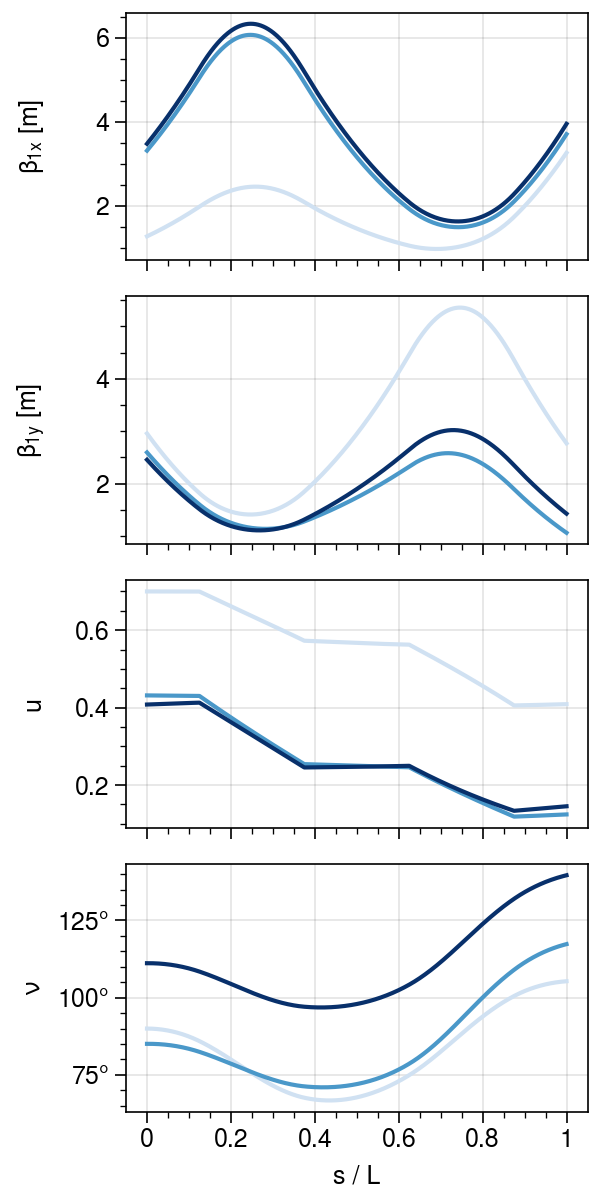

In [89]:
nshow = 3

kws = dict(lw=None, ls='-', legend=False, ms=1)

fig, axes = plot.subplots(nrows=4, ncols=1, figsize=(3, 6), spany=False, aligny=True)
_cycler = myplt.colorcycle(plot.Colormap('Blues'), nshow, start_end=(0.2, 1))
axes.set_prop_cycle(_cycler)
for stats in stats_lists['sdep'][:nshow]:
    n = stats.twiss4D.shape[0]
    for ax, col in zip(axes, ('bx', 'by', 'u', 'nu')):
        stats.twiss4D[['s/L', col]].plot('s/L', ax=ax, **kws)
    
axes.format(xlabel='s / L')
axes[-1].format(yformatter='deg')
myplt.set_labels(axes, [r'$\beta_{1x}$ [m]', r'$\beta_{1y}$ [m]', 'u', r'$\nu$'], 'ylabel')